In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import math
import os
import tqdm

import itertools
import functools

os.environ['R_HOME'] = '/home/trc891/.conda/envs/cfn_final/lib/R'

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, Formula, StrVector
pandas2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.rinterface_lib.embedded import RRuntimeError

deseq = importr('DESeq2')

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Impor

In [2]:
def plot_deseq2_ma(rdf, padj_cutoff=0.05, up_name=None, down_name=None,
                   labels=False, symbol_key=None, n_labeled_degs = 20):
    plt.plot(rdf['baseMean'], rdf['log2FoldChange'],
             '.', color='gray'
            )
    
    deg = rdf[rdf['padj'] < padj_cutoff].sort_values('log2FoldChange')
    up = deg[deg['log2FoldChange'] > 0]
    down = deg[deg['log2FoldChange'] < 0]
    
    plt.plot(up['baseMean'], up['log2FoldChange'],
             '.', color='firebrick'
            )
    
    plt.plot(down['baseMean'], down['log2FoldChange'],
             '.', color='darkblue'
            )
    
    if up_name:
        plt.text(np.max(rdf['baseMean']) * 0.05,
                 np.max(rdf['log2FoldChange']) * 0.8,
                 f'Up in {up_name}: {len(up)}'
                )
        
    if down_name:
        plt.text(np.max(rdf['baseMean']) * 0.05,
                 np.min(rdf['log2FoldChange']) * 0.8,
                 f'Up in {down_name}: {len(down)}'
                )
    
    # basic labeling code
    if labels:
        lb_deg = pd.concat([deg.head(int(n_labeled_degs/2)),
                            deg.tail(int(n_labeled_degs/2))])
        
        if symbol_key:
            lb = lb_deg[symbol_key]
        else:
            lb = lb_deg.index
        
        texts = []
        for x, y, s in zip(lb_deg['baseMean'], lb_deg['log2FoldChange'], lb):
            texts.append(plt.text(x, y, s))
    
    plt.xscale('log')
    plt.xlabel('log(mean counts)')
    plt.ylabel('log2FoldChange')

In [3]:
DATA_DIR = '../../data/10paper_figures/sc_files'
OUTPUT_DIR = '../../data/10paper_figures/fig5'

#SAMPLE_SHEET_PATH = f'{DATA_DIR}/CF_samples_2022_08_16_1000hvg.csv'
#sample_sheet = pd.read_csv(SAMPLE_SHEET_PATH)

ds = sc.read_h5ad(f'{DATA_DIR}/00scvi_2025_02_24_v1.h5ad')

#sample_sheet.sort_values('Class', ascending=False, inplace=True)

In [4]:
cluster_kw = 'cell_type_annot'

subj_ids = ds.obs['Sample'].unique()
clusters = ds.obs[cluster_kw].unique()

In [5]:
ds.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 6299462 stored elements and shape (89601, 1000)>

In [6]:
ds.raw.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 101232911 stored elements and shape (89601, 22039)>

In [7]:
ds.obs.columns

Index(['orig.ident', 'Doublet score', 'Library ID', 'Chemistry',
       'GEX library Index', 'Step 1 date YYYY/MM/DD', 'Project', 'Class',
       'Sample', 'Cell viabiliy', 'Age', 'Sex', 'Race', 'OnModulator',
       'Modulator', 'Include', 'Comments', 'n_genes', 'batch',
       'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes',
       'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels',
       'leiden', 'leiden_mod', 'leiden_unmerged', 'leiden_final',
       'cell_type_annot', 'cell_type_annot_unmerged', 'leiden_orig'],
      dtype='object')

In [8]:
MIN_CELLS_PER_CLUSTER = 10

psct_list = []
n_genes = ds.raw.X.shape[1]
n_clusters = len(clusters)

for subj_id in tqdm.tqdm(subj_ids):
    ct_mat = np.zeros((n_clusters, n_genes)) # we assume ds.raw.X is count data, unscaled
    n_cells = []

    for i, c in enumerate(clusters):
        cl_ds = ds[(ds.obs['Sample'] == subj_id) & (ds.obs[cluster_kw] == c)]
        pseudocounts = cl_ds.raw.X.sum(axis=0).A
        ct_mat[i,:] = pseudocounts
        n_cells.append(cl_ds.shape[0])

    subj_ds = pd.DataFrame(ct_mat, columns=cl_ds.raw.var.index)
    subj_ds.insert(0, 'n_cells', n_cells)
    subj_ds.insert(0, cluster_kw, clusters)
    subj_ds.insert(0, 'OnModulator', [ds[ds.obs['Sample'] == subj_id].obs['OnModulator'].iloc[0]] * len(clusters))
    subj_ds.insert(0, 'Class', [ds[ds.obs['Sample'] == subj_id].obs['Class'].iloc[0]] * len(clusters))
    subj_ds.insert(0, 'Sex', [ds[ds.obs['Sample'] == subj_id].obs['Sex'].iloc[0]] * len(clusters))
    subj_ds.insert(0, 'Sample', [ds[ds.obs['Sample'] == subj_id].obs['Sample'].iloc[0]] * len(clusters))
    
    new_index = list(subj_ds[['Sample', cluster_kw]].agg('_'.join, axis=1))
    subj_ds.insert(0, 'idx', new_index)
    subj_ds = subj_ds.set_index('idx')

    psct_list.append(subj_ds)
    
psct_df = pd.concat(psct_list)
psct_df.sort_values('Class', ascending=False, inplace=True) # Put NC values first so they are used as DESeq2 controls


# count filters

col_filt = [c for c in psct_df.columns[6:] if ((psct_df[c] > 50).sum() > 5)] # filter genes that don't have x samples with y counts
# col_filt = [c for c in psct_df.columns[6:] if (psct_df[c].sum() > 100)] # filter genes that don't have more than 50 reads
psct_df_filt_genes = psct_df[psct_df.columns[:6].tolist() + col_filt]

psct_df_filt_genes = psct_df_filt_genes[psct_df_filt_genes['n_cells'] > MIN_CELLS_PER_CLUSTER]

100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


In [9]:
psct_df

,Sample,Sex,Class,OnModulator,cell_type_annot,n_cells,A1BG,A1BG-AS1,A2M,A2M-AS1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
idx,,,,,,,,,,,,,,,,,,,,,
2020_3173_NC007_Stratified squamous,2020_3173_NC007,F,NC,NaN,Stratified squamous,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020_3173_NC004_Stromal,2020_3173_NC004,F,NC,NaN,Stromal,5,0.0,0.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0
2020-3173-NC008_CD4+ T-cells,2020-3173-NC008,M,NC,NaN,CD4+ T-cells,75,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,9.0,5.0
2020-3173-NC008_B-cells,2020-3173-NC008,M,NC,NaN,B-cells,10,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-3173-NC008_pDCs,2020-3173-NC008,M,NC,NaN,pDCs,11,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-3173-CF12_CD8+ T-cells,2020-3173-CF12,F,CF,No,CD8+ T-cells,9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-3173-CF12_Ionocytes,2020-3173-CF12,F,CF,No,Ionocytes,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-3173-CF12_CD4+ T-cells,2020-3173-CF12,F,CF,No,CD4+ T-cells,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
psct_df_filt_genes

,Sample,Sex,Class,OnModulator,cell_type_annot,n_cells,A2ML1,A4GALT,AAAS,AACS,...,ZSWIM8,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1
idx,,,,,,,,,,,,,,,,,,,,,
2020-3173-NC008_CD4+ T-cells,2020-3173-NC008,M,NC,NaN,CD4+ T-cells,75,0.0,2.0,2.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,9.0,5.0
2020-3173-NC008_pDCs,2020-3173-NC008,M,NC,NaN,pDCs,11,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0
2020_3173_NC003_Secretory,2020_3173_NC003,M,NC,NaN,Secretory,669,70.0,1090.0,52.0,41.0,...,93.0,17.0,23.0,43.0,13.0,10.0,74.0,95.0,299.0,144.0
2020_3173_NC003_Multiciliated,2020_3173_NC003,M,NC,NaN,Multiciliated,92,0.0,17.0,9.0,11.0,...,10.0,2.0,2.0,7.0,0.0,2.0,5.0,7.0,2.0,19.0
2020_3173_NC003_Suprabasal,2020_3173_NC003,M,NC,NaN,Suprabasal,376,14.0,424.0,20.0,18.0,...,52.0,4.0,11.0,17.0,10.0,10.0,28.0,37.0,183.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-3173-CF12_Monocytes,2020-3173-CF12,F,CF,No,Monocytes,11,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
2020-3173-CF12_Basal,2020-3173-CF12,F,CF,No,Basal,389,36.0,192.0,20.0,27.0,...,32.0,7.0,10.0,9.0,9.0,21.0,31.0,34.0,111.0,44.0
2020-3173-CF12_Keratinocytes,2020-3173-CF12,F,CF,No,Keratinocytes,96,14.0,34.0,0.0,6.0,...,8.0,7.0,3.0,2.0,4.0,1.0,6.0,2.0,44.0,17.0


In [11]:
DEG_output = {}
CELL_CUTOFF = 0

df = psct_df_filt_genes

for clust_id in clusters:
    filt_psct_df = df[(df['n_cells'] > CELL_CUTOFF) & (df[cluster_kw] == clust_id)]

    n_subj = psct_df[psct_df[cluster_kw] == clust_id].shape[0]
    print(f'cluster {clust_id}: {filt_psct_df.shape[0]} / {n_subj} subjects left after filtering')
    
    des_columns = filt_psct_df.iloc[:, :3]
    print(des_columns)
    
    n_cf = np.sum(des_columns['Class'] == 'CF')
    n_nc = np.sum(des_columns['Class'] == 'NC')
    
    if (n_cf > 3) & (n_nc > 3):
        R_des_columns = ro.DataFrame(des_columns)
        des_ct_matrix = filt_psct_df.iloc[:, 6:]
        dds = deseq.DESeqDataSetFromMatrix(countData=des_ct_matrix.T,
                                           colData=R_des_columns,
                                           design=Formula('~ Class + Sex'))
        try:
            dds = deseq.DESeq(dds)

            comparison = deseq.resultsNames(dds)
            to_dataframe = ro.r('function(x) data.frame(x)')
            deseq_result = to_dataframe(deseq.results(dds, contrast=StrVector(('Class', 'CF', 'NC'))))
            deseq_result = ro.pandas2ri.rpy2py(deseq_result)
            deseq_result['idx'] = des_ct_matrix.T.index

            DEG_output[clust_id] = deseq_result
        except RRuntimeError:
            print(f'failed cluster {clust_id}')
    else:
        print(f'failed cluster {clust_id}, , n_cf={n_cf}, n_nc={n_nc}')

cluster Secretory: 16 / 16 subjects left after filtering
                                    Sample Sex Class
idx                                                 
2020_3173_NC003_Secretory  2020_3173_NC003   M    NC
2020-3173-NC002_Secretory  2020-3173-NC002   M    NC
2020-3173-NC008_Secretory  2020-3173-NC008   M    NC
2020_3173_NC004_Secretory  2020_3173_NC004   F    NC
2020_3173_NC007_Secretory  2020_3173_NC007   F    NC
2020_3173_NC005_Secretory  2020_3173_NC005   F    NC
2020_3173_NC006_Secretory  2020_3173_NC006   M    NC
2020_3173_01CF_Secretory    2020_3173_01CF   F    CF
2020_3173_CF07_Secretory    2020_3173_CF07   M    CF
2020_3173_CF03_Secretory    2020_3173_CF03   F    CF
2020_3173_CF02_Secretory    2020_3173_CF02   M    CF
2020-3173-CF10_Secretory    2020-3173-CF10   M    CF
2020-3173-CF15_Secretory    2020-3173-CF15   F    CF
2020-3173-CF14_Secretory    2020-3173-CF14   M    CF
2020-3173-CF12_Secretory    2020-3173-CF12   F    CF
2020-3173-CF20_Secretory    2020-3173-CF20

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



cluster Multiciliated: 13 / 16 subjects left after filtering
                                        Sample Sex Class
idx                                                     
2020_3173_NC003_Multiciliated  2020_3173_NC003   M    NC
2020_3173_NC004_Multiciliated  2020_3173_NC004   F    NC
2020-3173-NC002_Multiciliated  2020-3173-NC002   M    NC
2020-3173-NC008_Multiciliated  2020-3173-NC008   M    NC
2020_3173_NC007_Multiciliated  2020_3173_NC007   F    NC
2020_3173_NC005_Multiciliated  2020_3173_NC005   F    NC
2020_3173_NC006_Multiciliated  2020_3173_NC006   M    NC
2020_3173_01CF_Multiciliated    2020_3173_01CF   F    CF
2020_3173_CF07_Multiciliated    2020_3173_CF07   M    CF
2020_3173_CF03_Multiciliated    2020_3173_CF03   F    CF
2020_3173_CF02_Multiciliated    2020_3173_CF02   M    CF
2020-3173-CF15_Multiciliated    2020-3173-CF15   F    CF
2020-3173-CF10_Multiciliated    2020-3173-CF10   M    CF


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



cluster Suprabasal: 16 / 16 subjects left after filtering
                                     Sample Sex Class
idx                                                  
2020_3173_NC003_Suprabasal  2020_3173_NC003   M    NC
2020_3173_NC004_Suprabasal  2020_3173_NC004   F    NC
2020-3173-NC002_Suprabasal  2020-3173-NC002   M    NC
2020-3173-NC008_Suprabasal  2020-3173-NC008   M    NC
2020_3173_NC007_Suprabasal  2020_3173_NC007   F    NC
2020_3173_NC006_Suprabasal  2020_3173_NC006   M    NC
2020_3173_NC005_Suprabasal  2020_3173_NC005   F    NC
2020-3173-CF20_Suprabasal    2020-3173-CF20   M    CF
2020_3173_CF03_Suprabasal    2020_3173_CF03   F    CF
2020_3173_CF07_Suprabasal    2020_3173_CF07   M    CF
2020_3173_01CF_Suprabasal    2020_3173_01CF   F    CF
2020_3173_CF02_Suprabasal    2020_3173_CF02   M    CF
2020-3173-CF14_Suprabasal    2020-3173-CF14   M    CF
2020-3173-CF15_Suprabasal    2020-3173-CF15   F    CF
2020-3173-CF10_Suprabasal    2020-3173-CF10   M    CF
2020-3173-CF12_Suprabasa

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



cluster Monocytes: 3 / 16 subjects left after filtering
                                    Sample Sex Class
idx                                                 
2020_3173_NC003_Monocytes  2020_3173_NC003   M    NC
2020_3173_CF07_Monocytes    2020_3173_CF07   M    CF
2020-3173-CF12_Monocytes    2020-3173-CF12   F    CF
failed cluster Monocytes, , n_cf=2, n_nc=1
cluster Basal: 16 / 16 subjects left after filtering
                                Sample Sex Class
idx                                             
2020_3173_NC003_Basal  2020_3173_NC003   M    NC
2020_3173_NC004_Basal  2020_3173_NC004   F    NC
2020-3173-NC002_Basal  2020-3173-NC002   M    NC
2020-3173-NC008_Basal  2020-3173-NC008   M    NC
2020_3173_NC006_Basal  2020_3173_NC006   M    NC
2020_3173_NC007_Basal  2020_3173_NC007   F    NC
2020_3173_NC005_Basal  2020_3173_NC005   F    NC
2020-3173-CF20_Basal    2020-3173-CF20   M    CF
2020_3173_CF03_Basal    2020_3173_CF03   F    CF
2020_3173_CF07_Basal    2020_3173_CF07   M  

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



cluster Keratinocytes: 15 / 16 subjects left after filtering
                                        Sample Sex Class
idx                                                     
2020_3173_NC003_Keratinocytes  2020_3173_NC003   M    NC
2020_3173_NC004_Keratinocytes  2020_3173_NC004   F    NC
2020-3173-NC002_Keratinocytes  2020-3173-NC002   M    NC
2020-3173-NC008_Keratinocytes  2020-3173-NC008   M    NC
2020_3173_NC007_Keratinocytes  2020_3173_NC007   F    NC
2020_3173_NC006_Keratinocytes  2020_3173_NC006   M    NC
2020_3173_NC005_Keratinocytes  2020_3173_NC005   F    NC
2020-3173-CF20_Keratinocytes    2020-3173-CF20   M    CF
2020_3173_CF03_Keratinocytes    2020_3173_CF03   F    CF
2020_3173_CF07_Keratinocytes    2020_3173_CF07   M    CF
2020_3173_CF02_Keratinocytes    2020_3173_CF02   M    CF
2020-3173-CF14_Keratinocytes    2020-3173-CF14   M    CF
2020-3173-CF15_Keratinocytes    2020-3173-CF15   F    CF
2020-3173-CF10_Keratinocytes    2020-3173-CF10   M    CF
2020-3173-CF12_Keratinocyte

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



cluster Dendritic: 5 / 16 subjects left after filtering
                                    Sample Sex Class
idx                                                 
2020_3173_NC003_Dendritic  2020_3173_NC003   M    NC
2020-3173-NC002_Dendritic  2020-3173-NC002   M    NC
2020_3173_NC004_Dendritic  2020_3173_NC004   F    NC
2020_3173_NC005_Dendritic  2020_3173_NC005   F    NC
2020_3173_CF02_Dendritic    2020_3173_CF02   M    CF
failed cluster Dendritic, , n_cf=1, n_nc=4
cluster Stromal: 2 / 16 subjects left after filtering
                                  Sample Sex Class
idx                                               
2020-3173-NC008_Stromal  2020-3173-NC008   M    NC
2020_3173_NC007_Stromal  2020_3173_NC007   F    NC
failed cluster Stromal, , n_cf=0, n_nc=2
cluster Mast: 5 / 16 subjects left after filtering
                               Sample Sex Class
idx                                            
2020_3173_NC003_Mast  2020_3173_NC003   M    NC
2020-3173-NC002_Mast  2020-3173-NC00

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



cluster CD8+ T-cells: 7 / 16 subjects left after filtering
                                       Sample Sex Class
idx                                                    
2020_3173_NC003_CD8+ T-cells  2020_3173_NC003   M    NC
2020-3173-NC008_CD8+ T-cells  2020-3173-NC008   M    NC
2020-3173-NC002_CD8+ T-cells  2020-3173-NC002   M    NC
2020_3173_NC006_CD8+ T-cells  2020_3173_NC006   M    NC
2020_3173_NC004_CD8+ T-cells  2020_3173_NC004   F    NC
2020_3173_NC005_CD8+ T-cells  2020_3173_NC005   F    NC
2020-3173-CF15_CD8+ T-cells    2020-3173-CF15   F    CF
failed cluster CD8+ T-cells, , n_cf=1, n_nc=6
cluster Ionocytes: 4 / 16 subjects left after filtering
                                    Sample Sex Class
idx                                                 
2020_3173_NC006_Ionocytes  2020_3173_NC006   M    NC
2020_3173_NC004_Ionocytes  2020_3173_NC004   F    NC
2020_3173_CF07_Ionocytes    2020_3173_CF07   M    CF
2020-3173-CF15_Ionocytes    2020-3173-CF15   F    CF
failed cluster Io

In [12]:
for cluster in DEG_output.keys():
    print(f'Cluster {cluster}')
    print(DEG_output[cluster][DEG_output[cluster]['padj'] < 0.05].sort_values('log2FoldChange'))
    print('\n')

Cluster Secretory
                baseMean  log2FoldChange     lfcSE      stat        pvalue  \
HLA-DRB5      237.942308       -2.165800  0.382569 -5.661198  1.503194e-08   
EGR1           27.290183       -1.999845  0.449914 -4.444946  8.791391e-06   
LGALS9B        36.665409       -1.524896  0.365747 -4.169268  3.055792e-05   
MPV17L         94.774857       -1.008032  0.235055 -4.288489  1.798924e-05   
UBTD1          83.365753       -0.804366  0.153367 -5.244717  1.565220e-07   
PELI1         116.033962       -0.765761  0.183310 -4.177418  2.948364e-05   
NINJ1         134.887904       -0.637016  0.144798 -4.399348  1.085764e-05   
UBE2B         216.249633       -0.514378  0.125460 -4.099953  4.132348e-05   
NSUN5          97.863422        0.597994  0.148387  4.029972  5.578341e-05   
INTS6          74.994851        0.606413  0.149779  4.048723  5.149777e-05   
C5orf63        43.851315        0.680941  0.164145  4.148412  3.347897e-05   
TMEM161B-AS1  138.655747        0.705114  0.16

In [31]:
DEG_output['Macrophages'][DEG_output['Macrophages']['padj'] < 0.05].sort_values('log2FoldChange')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,idx
HLA-DQA2,19.285692,-3.116139,0.726838,-4.287253,1.808962e-05,2.665687e-03,HLA-DQA2
SELENOP,11.929676,-2.893435,0.833653,-3.470790,5.189297e-04,2.562044e-02,SELENOP
HLA-DRB5,93.787337,-2.043765,0.308353,-6.628007,3.402487e-11,1.942820e-08,HLA-DRB5
LGMN,23.148228,-1.603523,0.504141,-3.180703,1.469183e-03,4.660574e-02,LGMN
ARHGDIB,12.165978,-1.250482,0.341147,-3.665519,2.468373e-04,1.761801e-02,ARHGDIB
SYNGR2,14.285370,-1.228722,0.355033,-3.460870,5.384330e-04,2.562044e-02,SYNGR2
ITM2B,74.599720,-0.896687,0.272284,-3.293199,9.905441e-04,3.861452e-02,ITM2B
CD74,867.898532,-0.839103,0.200939,-4.175910,2.967965e-05,3.389416e-03,CD74
TMSB4X,161.750039,-0.753533,0.202818,-3.715316,2.029501e-04,1.655493e-02,TMSB4X
HLA-DRA,230.997390,-0.670469,0.208248,-3.219560,1.283875e-03,4.312309e-02,HLA-DRA


## Sanity Check

Let's make sure these are going in the right direction.

In [13]:
norm_psct_df = psct_df_filt_genes.copy()
cts = norm_psct_df.iloc[:, 6:]
norm_cts = cts.div(cts.sum(axis=1), axis=0) * 1e6 # normalize rows, gets CPM
norm_psct_df.iloc[:, 6:] = norm_cts

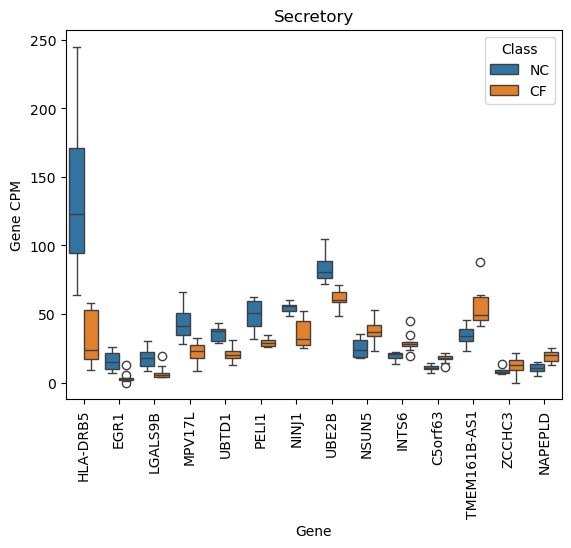

In [22]:
cell_type = 'Secretory'
gene_list = list(DEG_output[cell_type][DEG_output[cell_type]['padj'] < 0.05].sort_values('log2FoldChange').index)


foo = norm_psct_df.loc[norm_psct_df['cell_type_annot'] == cell_type,
                                      ['Class'] + gene_list
                                     ]

bar = foo.melt(id_vars='Class')

sns.boxplot(bar,
               x='variable',
               y='value',
               hue='Class'
               )
plt.xlabel('Gene')
plt.xticks(rotation=90)
plt.ylabel('Gene CPM')
plt.title(cell_type)

plt.show()

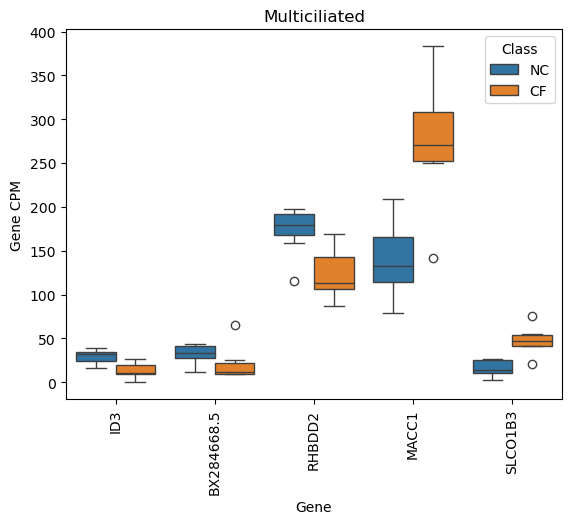

In [26]:
cell_type = 'Multiciliated'
gene_list = list(DEG_output[cell_type][DEG_output[cell_type]['padj'] < 0.05].sort_values('log2FoldChange').index)

foo = norm_psct_df.loc[norm_psct_df['cell_type_annot'] == cell_type,
                                      ['Class'] + gene_list
                                     ]

bar = foo.melt(id_vars='Class')

sns.boxplot(bar,
               x='variable',
               y='value',
               hue='Class'
               )
plt.xlabel('Gene')
plt.xticks(rotation=90)
plt.ylabel('Gene CPM')
plt.title(cell_type)

plt.show()

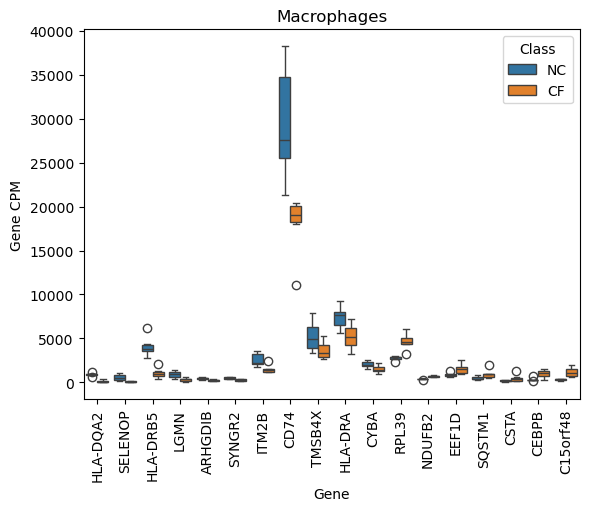

In [27]:
cell_type = 'Macrophages'
gene_list = list(DEG_output[cell_type][DEG_output[cell_type]['padj'] < 0.05].sort_values('log2FoldChange').index)

foo = norm_psct_df.loc[norm_psct_df['cell_type_annot'] == cell_type,
                                      ['Class'] + gene_list
                                     ]

bar = foo.melt(id_vars='Class')

sns.boxplot(bar,
               x='variable',
               y='value',
               hue='Class'
               )
plt.xlabel('Gene')
plt.xticks(rotation=90)
plt.ylabel('Gene CPM')
plt.title(cell_type)

plt.show()